# Navigation

---

Congratulations for completing the first project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893)!  In this notebook, you will learn how to control an agent in a more challenging environment, where it can learn directly from raw pixels!  **Note that this exercise is optional!**

### 1. Start the Environment

We begin by importing some necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# https://github.com/Unity-Technologies/ml-agents/issues/1883

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/VisualBanana.app"`
- **Windows** (x86): `"path/to/VisualBanana_Windows_x86/Banana.exe"`
- **Windows** (x86_64): `"path/to/VisualBanana_Windows_x86_64/Banana.exe"`
- **Linux** (x86): `"path/to/VisualBanana_Linux/Banana.x86"`
- **Linux** (x86_64): `"path/to/VisualBanana_Linux/Banana.x86_64"`
- **Linux** (x86, headless): `"path/to/VisualBanana_Linux_NoVis/Banana.x86"`
- **Linux** (x86_64, headless): `"path/to/VisualBanana_Linux_NoVis/Banana.x86_64"`

For instance, if you are using a Mac, then you downloaded `VisualBanana.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="VisualBanana.app")
```

In [2]:
env = UnityEnvironment(file_name="VisualBanana.app", no_graphics=False)

Mono path[0] = '/Users/dmitrimanajev/Dev_Code/Udacity/Deep_Reinforcement2/Value-based-methods/p1_navigation/visual/VisualBanana.app/Contents/Resources/Data/Managed'
Mono config path = '/Users/dmitrimanajev/Dev_Code/Udacity/Deep_Reinforcement2/Value-based-methods/p1_navigation/visual/VisualBanana.app/Contents/MonoBleedingEdge/etc'


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 1
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 0
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The environment state is an array of raw pixels with shape `(1, 84, 84, 3)`.  *Note that this code differs from the notebook for the project, where we are grabbing **`visual_observations`** (the raw pixels) instead of **`vector_observations`**.* A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

Number of agents: 1
Number of actions: 4
States look like:


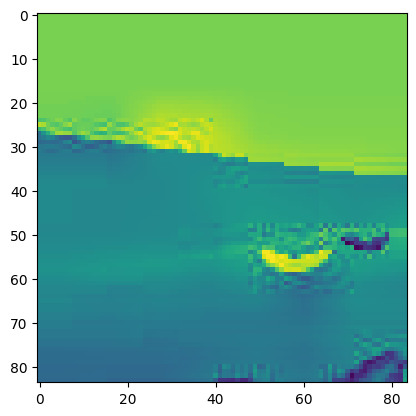

States have shape: (4, 84, 84)


In [4]:
from image_preprocessor import DQNPreprocessor

# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.visual_observations[0]
print('States look like:')
plt.imshow(np.squeeze(state))
frame_processor = DQNPreprocessor()

state = frame_processor.get_state(state)
plt.imshow(state[0])
plt.show()
state_size = state.shape
print('States have shape:', state.shape)

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [5]:
from image_preprocessor import DQNPreprocessor
from collections import deque
import torch
import matplotlib.pyplot as plt
%matplotlib inline

import json
import os


def log_to_json(file_path, agent_name, params, episode_data):
    # Step 1: Load existing data if the file exists and is non-empty
    if os.path.exists(file_path) and os.path.getsize(file_path) > 0:
        with open(file_path, 'r') as file:
            data = json.load(file)
    else:
        data = {}  # Initialize as empty if the file doesn’t exist or is empty

    # Step 2: Update data with new information
    if agent_name not in data:
        data[agent_name] = {"parameters": params, "episodes_data": {}}
    
    # Add episode data as a new trial
    data[agent_name]["episodes_data"] = episode_data

    # Step 3: Write updated data back to the file
    with open(file_path, 'w') as file:
        json.dump(data, file, indent=2, separators=(',', ': '))

def dqn(agent, n_episodes=1500, max_t=1000, eps_start=1.0, eps_end=0.05, eps_decay=0.995, frame_skipping=1):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    best_average = -float('inf')       # track best average score
    best_model_path = None             # store path of the best model
    is_solved = False                  # solved when has > 15 score
    episodes_to_solve = 0
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
         # get frame from emulator
        frame = env_info.visual_observations[0]

        # set deque to store frames stack to input the neural network
        frame_processor = DQNPreprocessor()

        state = frame_processor.get_state(frame)

        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            accumulated_reward = 0  # accumulate reward for repeated actions
            
            # Repeat the action 'frame_skipping' times
            for _ in range(frame_skipping):
                env_info = env.step(action)[brain_name]
                next_frame = env_info.visual_observations[0]
                next_state = frame_processor.get_state(next_frame)
                reward = env_info.rewards[0]                
                done = env_info.local_done[0]
             
                accumulated_reward += reward  # accumulate reward
                if done:  # end loop if the episode ends
                    break
            
            # Update the agent with the accumulated reward and next state
            agent.step(state, action, accumulated_reward, next_state, done)
            state = next_state  # move to the next state
            score += accumulated_reward  # accumulate episode score
            
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon

        avg_score = np.mean(scores_window)
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, avg_score), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, avg_score))

        # Stop if environment is solved
        if avg_score >= 13:
            if not is_solved:
                print(f'\nEnvironment solved in {i_episode - 100} episodes!\tAverage Score: {avg_score:.2f}')
                is_solved = True
                episodes_to_solve = i_episode - 100
            # Check if current average is the best so far
            if avg_score > best_average:
                best_average = avg_score
                # Define a filename for saving model based on parameters
                best_model_path = f'checkpoint_{agent.name}.pth'
                torch.save(agent.qnetwork_local.state_dict(), best_model_path)
                print(f'\nBest model saved with average score: {best_average:.2f} at {best_model_path}')

    return scores, best_average, episodes_to_solve

In [ ]:
from dqn_agent import Agent

agent = Agent(state_size=state_size, action_size=action_size, name='Dueling DDQN', 
              learning_rate=5e-4,
              batch_size=32,
              tau=1e-3,
              buffer_size=int(1e5),
              is_double=True, is_prioritzed=False, is_dueling=True)
# replay_filename='proportional_replay_buffer.pkl'

# if os.path.exists(replay_filename) and os.path.getsize(replay_filename) > 0:
#     agent.memory.load_buffer(replay_filename)
# else:
#     prefill_buffer(agent, int(1e5), replay_filename)

scores, best_average, episodes_to_solve = dqn(agent, n_episodes=500, eps_start=1.0, eps_end=0.05, eps_decay=0.995)
log_to_json('performance.json', 'Dueling DDQN', {
    "BUFFER_SIZE": int(1e5), # next to try 5e5
    "BATCH_SIZE": 32, 
    "GAMMA": 0.99,
    "TAU": 1e-3,
    "LR": 5e-4, 
    "UPDATE_EVERY": 4,
    "EPS_START": 1,
    "EPS_END":0.05,
    "EPS_DECAY":0.99 # try 0.992
}, {
    "episodes": scores,
    "best_average": best_average,
    "episodes_to_solve": episodes_to_solve
})
#   Reduced learning rate for stability

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

MPS backend is available. Using MPS.
Episode 36	Average Score: 0.179